epoch:1 ,Loss: 0.3063315451145172, train accuracy: 88.6243%, test accuracy: 57.2491%
epoch:5 ,Loss: 0.19014401733875275, train accuracy: 93.3091%, test accuracy: 44.4232%
epoch:10 ,Loss: 0.13281765580177307, train accuracy: 95.2815%, test accuracy: 86.6143%
epoch:15 ,Loss: 0.09077908843755722, train accuracy: 96.6050%, test accuracy: 86.0475%
epoch:20 ,Loss: 0.07502150535583496, train accuracy: 97.0513%, test accuracy: 86.7447%
epoch:25 ,Loss: 0.0674034133553505, train accuracy: 97.2874%, test accuracy: 87.0667%
epoch:30 ,Loss: 0.06209396570920944, train accuracy: 97.4699%, test accuracy: 87.6335%
epoch:35 ,Loss: 0.058482542634010315, train accuracy: 97.5897%, test accuracy: 86.9657%
epoch:40 ,Loss: 0.055440761148929596, train accuracy: 97.6994%, test accuracy: 86.8728%
epoch:45 ,Loss: 0.05329916253685951, train accuracy: 97.7748%, test accuracy: 86.1963%
epoch:50 ,Loss: 0.05152583494782448, train accuracy: 97.8423%, test accuracy: 87.0399%
overall Accuracy: 22.8626%


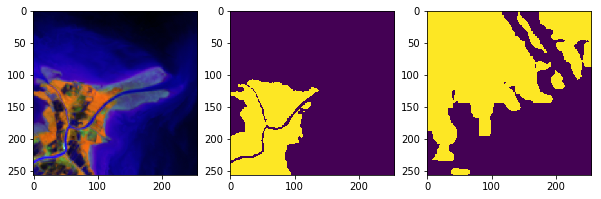

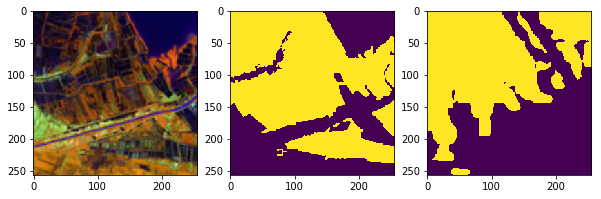

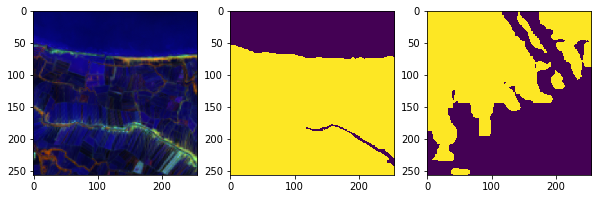

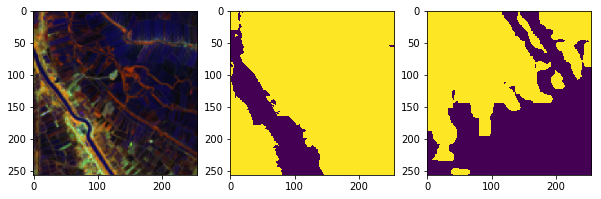

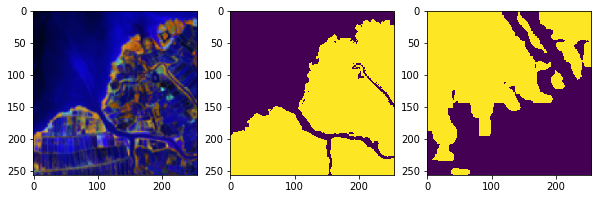

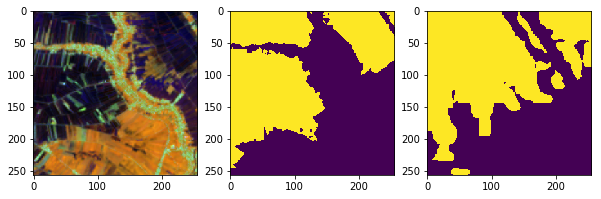

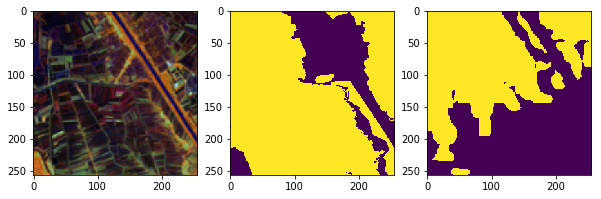

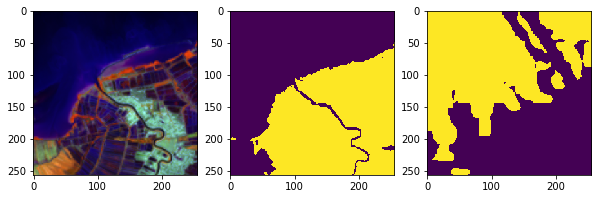

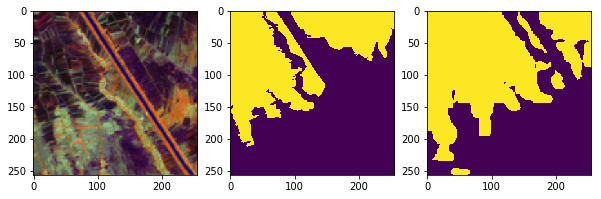

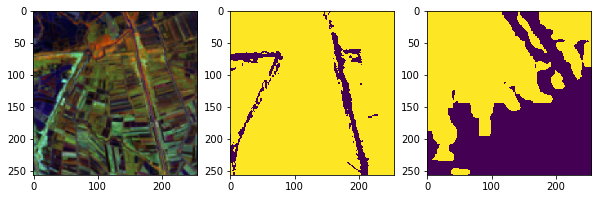

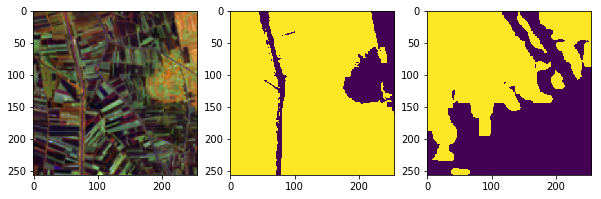

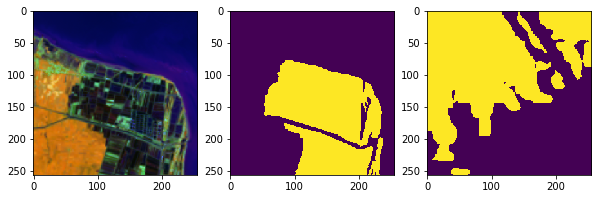

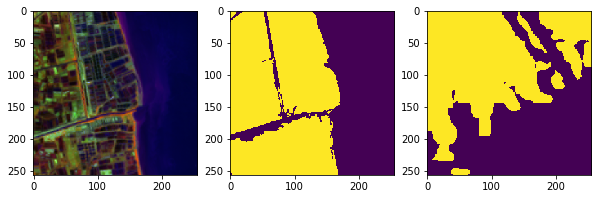

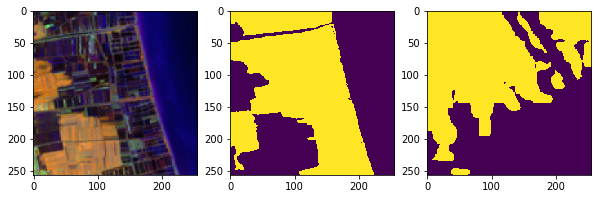

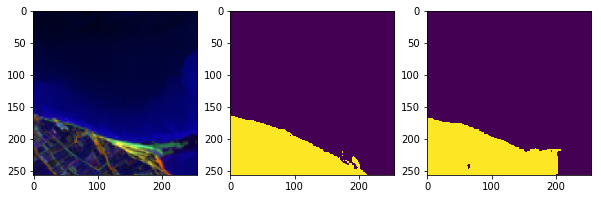

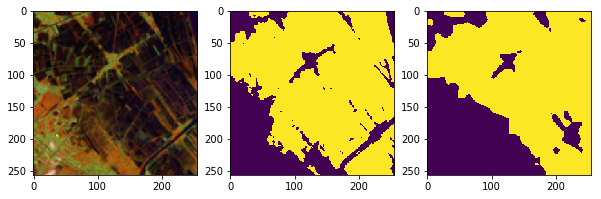

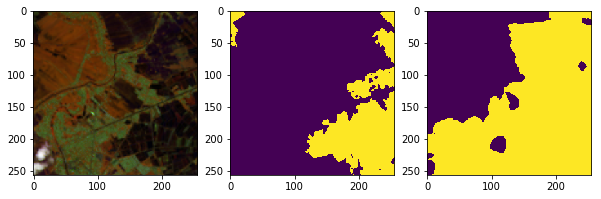

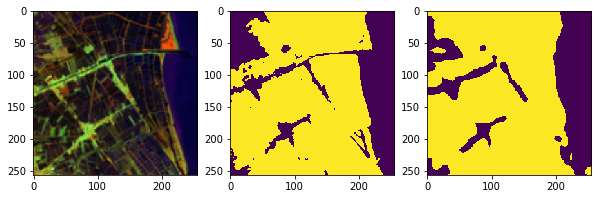

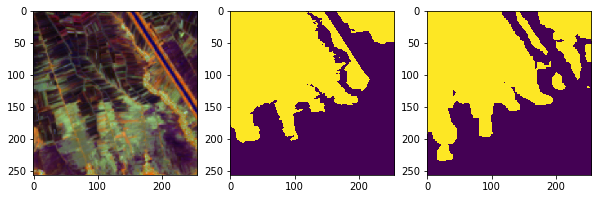

In [75]:
import sys
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tfs
# from torchvision.datasets import CIFAR10
from datetime import datetime
import os
import gdal
import matplotlib.pyplot as plt
%matplotlib inline

def conv3x3(in_channel, out_channel, stride=1):
    return nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)

class residual_block(nn.Module):
    def __init__(self, in_channel, out_channel, same_shape=True):
        super(residual_block, self).__init__()
        self.same_shape = same_shape
        stride=1 if self.same_shape else 2
        
        self.conv1 = conv3x3(in_channel, out_channel, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        
        self.conv2 = conv3x3(out_channel, out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)
        if not self.same_shape:
            self.conv3 = nn.Conv2d(in_channel, out_channel, 1, stride=stride)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out), True)
        out = self.conv2(out)
        out = F.relu(self.bn2(out), True)
        
        if not self.same_shape:
            x = self.conv3(x)
        return F.relu(x+out, True)
    
class resnet(nn.Module):
    def __init__(self, in_channel, verbose=False):
        super(resnet, self).__init__()
        self.verbose = verbose
        
        self.block1 = nn.Conv2d(in_channel, 64, 7, 2)
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(3, 2),
            residual_block(64, 64),
            residual_block(64, 64)
        )
        
        self.block3 = nn.Sequential(
            residual_block(64, 128, False),
            residual_block(128, 128)
        )
        
        self.block4 = nn.Sequential(
            residual_block(128, 256, False),
            residual_block(256, 256)
        )
        
        self.block5 = nn.Sequential(
            residual_block(256, 512, False),
            residual_block(512, 512)
        )
        
        
    def forward(self, x):
        x = self.block1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
        x = self.block2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
        x = self.block3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
        x = self.block4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
        x = self.block5(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = x.view(x.shape[0], -1)
        return x
    
aresnet= resnet(7,True)

def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn,self).__init__()
        
        self.stage1=nn.Sequential(*list(aresnet.children())[:-2]) #128
        self.stage2=nn.Sequential(*list(aresnet.children())[-2])  #256
        self.stage3=nn.Sequential(*list(aresnet.children())[-1])  #512
        
        self.scores1=nn.Conv2d(512,num_classes,1)
        self.scores2=nn.Conv2d(256,num_classes,1)
        self.scores3=nn.Conv2d(128,num_classes,1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 0, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) 
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 3, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 3)
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) 
    
    def forward(self, x):
        x = self.stage1(x)
        s1 = x # 1/8
        
        x = self.stage2(x)
        s2 = x # 1/16
        
        x = self.stage3(x)
        s3 = x # 1/32
        
        s3 = self.scores1(s3) 
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2
        s = self.upsample_8x(s)
        return s
    
    
net=fcn(2)
net=net.cuda()
criterion=nn.NLLLoss()
optimizer=torch.optim.SGD(net.parameters(),lr=1e-2,weight_decay=1e-4)


band_fns= [im for im in os.listdir('./data/2014_121_64/croppedrst/') if (im.split('.')[-1]=='rst')]
bands_dict={}
for i in range(8):
    in_ds=gdal.Open('./data/2014_121_64/croppedrst/'+band_fns[i])
    in_band=in_ds.GetRasterBand(1)
    bands_dict['b{}'.format(i+1)]=in_band.ReadAsArray().astype('float')
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor
def flip_train():
    acc=0
    out=net(traindata)
    out=F.log_softmax(out,dim=1)
    loss=criterion(out,label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred_labels=out.max(dim=1)[1]
    acc=(pred_labels==label).sum().item()/(label.size(1)*label.size(2))
    acclist.append(acc)
    losssublist.append(loss.data)
def plot_results():
    _,figs=plt.subplots(1,3,figsize=(10,10))
    band4=traindata[:,3,:,:].cpu().view(1,256,256)
    band6=traindata[:,5,:,:].cpu().view(1,256,256)
    band5=traindata[:,4,:,:].cpu().view(1,256,256)
    aimg=torch.cat((band5,band6,band4),0).permute(1,2,0)
    bimg=label.cpu().view(256,256)
    cimg=pred_labels.view(256,256)
    figs[0].imshow(aimg)
    figs[1].imshow(bimg)
    figs[2].imshow(cimg)
    
    
index= [(im.split('.')[0].split('IMG')[1].split('_')) for im in os.listdir('./data/2014_121_64/croppedtraining128tif/')]
xtestindex=[int(torch.randint(3700,4500,(1,)).item()) for i in range(50)]
ytestindex=[int(torch.randint(3400,4700,(1,)).item()) for i in range(50)]
losslist=[]
testloss=[]



for epoch in range(50):#train 50 times
    losssublist=[]
    acclist=[]
    for i in range(len(index)):
        abatch=[]
        x=int(index[i][0])
        y=int(index[i][1])
        for j in range(8):
            img=bands_dict['b{}'.format(j+1)]
            img=torch.from_numpy(img[x-128:x+128,y-128:y+128]).unsqueeze(0)
            if j<7:
                img=min_max_normalization(img,0,1)
            abatch.append(img)
        abatch=tuple(abatch) 
        traindata=Variable(torch.cat(abatch[:-1],0).unsqueeze(0).float().cuda())
        label=Variable(abatch[-1].long().cuda())
        net=net.train()
        for flipt in range(4):
            if flipt ==0:
                flip_train()
            if flipt == 1:
                traindata=torch.flip(traindata,[2])
                label=torch.flip(label,[1])
                flip_train()
            if flipt == 2:
                traindata=torch.flip(traindata,[3])
                label=torch.flip(label,[2])
                flip_train()
            if flipt == 3:
                traindata=torch.flip(traindata,[2,3])
                label=torch.flip(label,[1,2])
                flip_train()
        
            
    meanacc=sum(acclist) / float(len(acclist))
    meanloss=sum(losssublist)/ float(len(losssublist))

    losslist.append(meanloss)
        
    testsubloss=[]   
    testacclist=[]
    
    for testepoch in range(50):# 50 test images
        batch_1=[]
        x=xtestindex[testepoch]
        y=ytestindex[testepoch]
        for j in range(8):
            img=bands_dict['b{}'.format(j+1)]
            img=torch.from_numpy(img[x-128:x+128,y-128:y+128]).unsqueeze(0)
            if j<7:
                img=min_max_normalization(img,0,1)
            batch_1.append(img)
        batch_1=tuple(batch_1)
        traindata=torch.cat(batch_1[:-1],0).unsqueeze(0).float().cuda()
        label=batch_1[-1].long().cuda()

        net=net.eval()
        out=net(traindata)
        out=F.log_softmax(out,dim=1)
        loss=criterion(out,label)
        testsubloss.append(loss.data)
        
        pred_labels=out.max(dim=1)[1]
        acc=(pred_labels==label).sum().item()/(label.size(1)*label.size(2))
        testacclist.append(acc)

        if epoch==49 and (testepoch+1)%10==0:
            plot_results()
    testsublossmean=sum(testsubloss)/float(len(testsubloss))
    testaccmean=sum(testacclist)/float(len(testacclist))
    testloss.append(testsublossmean)
    if ((epoch+1)%5==0 or epoch==0):
        print('epoch:{} ,Loss: {}, train accuracy: {:.4f}%, test accuracy: {:.4f}%'.format(epoch+1,meanloss,meanacc*100.0,testaccmean*100))
    
    
    
# write results
acclist=[]  
out_ds_pred = gdal.GetDriverByName('GTiff').Create('./data/2014_121_64/pred_results/pred_reults.tif',7168,7168, 1, 1)
for xepo in range(28):
    for yepo in range(28):
        acc=0
        batch_1=[]
        x=xepo*256
        y=yepo*256
        for j in range(8):
            img=bands_dict['b{}'.format(j+1)]
            img=torch.from_numpy(img[x:x+256,y:y+256]).unsqueeze(0)
            if j<7:
                img=min_max_normalization(img,0,1)
            batch_1.append(img)
        batch_1=tuple(batch_1)
        traindata=torch.cat(batch_1[:-1],0).unsqueeze(0).float().cuda()
        label=batch_1[-1].long().cuda()

        net=net.eval()
        out=net(traindata)
        out=F.log_softmax(out,dim=1)
        loss=criterion(out,label)

        pred_labels=out.max(dim=1)[1]
        acc=(pred_labels==label).sum().item()/(label.size(1)*label.size(2))
        acclist.append(acc)

        pred_labelnumpy=pred_labels.view(256,256).cpu().numpy()
        out_band_pred=out_ds_pred.GetRasterBand(1)
        out_band_pred.WriteArray(pred_labelnumpy,y,x)
        
out_band_pred.ComputeStatistics(False)
out_ds_pred.SetProjection(in_ds.GetProjection())
out_ds_pred.SetGeoTransform((in_ds.GetGeoTransform()[0], 15.0, 0.0, in_ds.GetGeoTransform()[3], 0.0, -15.0))
out_ds_pred.FlushCache()
del out_ds_pred

meanacc=sum(acclist) / float(len(acclist))
print('overall Accuracy: {:.4f}%'.format(meanacc*100.0))
torch.save(net.state_dict(), './netdict_resnetANDfcn.pth')

In [ ]:
import os

index= [(im.split('.')[0].split('IMG')[1].split('_')) for im in os.listdir('./data/2014_121_64/croppedtraining128tif/')]
print(index[0][0])
print(len(index))

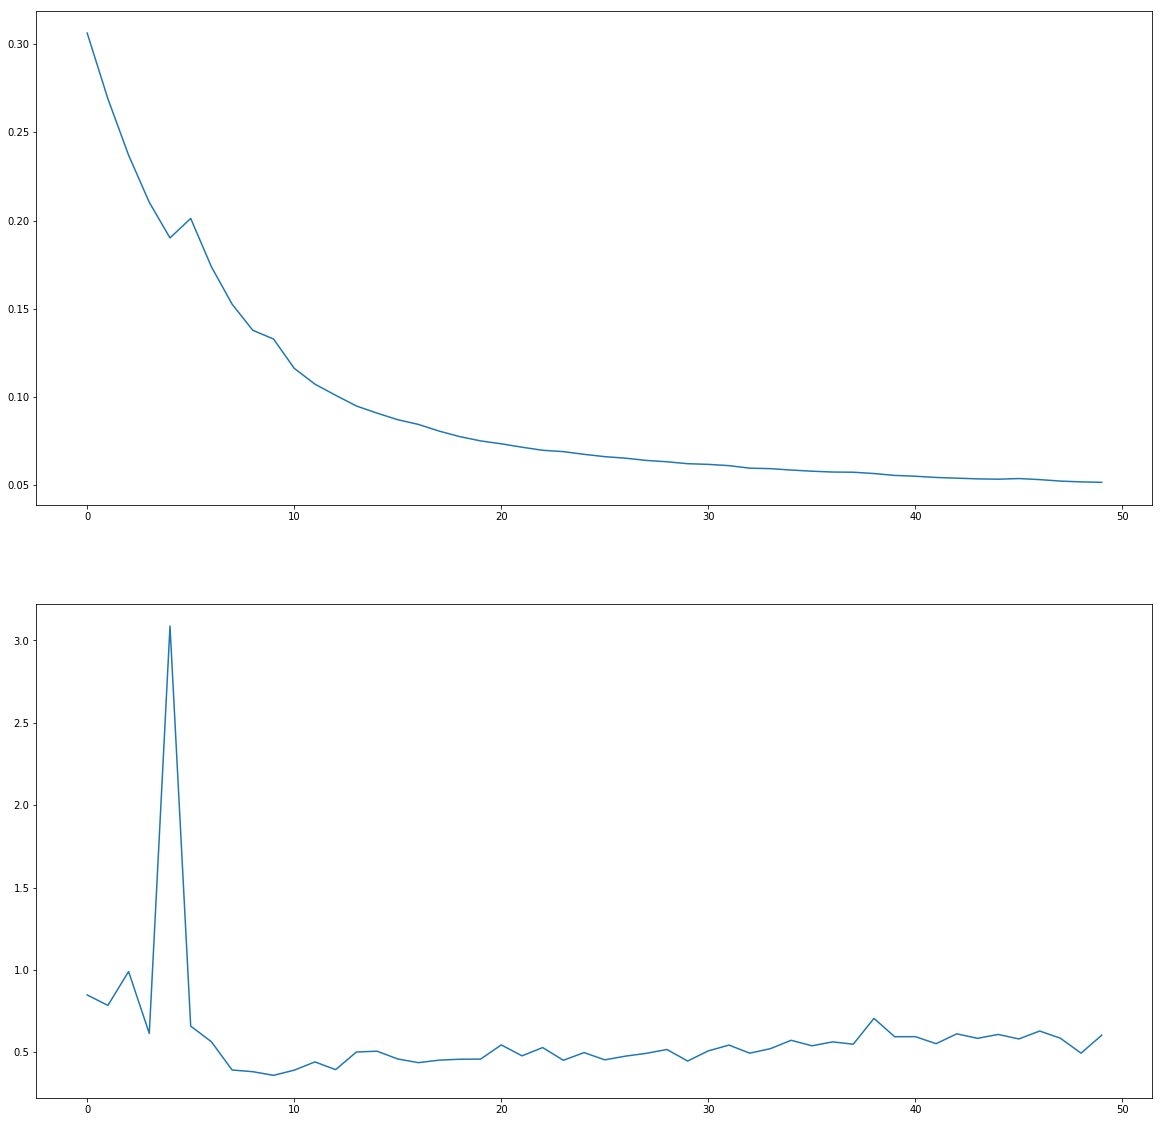

In [76]:
t = np.arange(0, len(losslist), 1)
_,figs=plt.subplots(2,1,figsize=(20,20))
figs[0].plot(t, losslist)
figs[1].plot(t,testloss)


In [77]:
band_fns= [im for im in os.listdir('./data/2014_121_64/bluo/clipped/') if (im.split('.')[-1]=='rst')]
bands_dict={}
for i in range(8):
    in_ds=gdal.Open('./data/2014_121_64/bluo/clipped/'+band_fns[i])
    in_band=in_ds.GetRasterBand(1)
    bands_dict['b{}'.format(i+1)]=in_band.ReadAsArray().astype('float')
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


# write results
acclist=[]  
out_ds_pred = gdal.GetDriverByName('GTiff').Create('./data/2014_121_64/bluo/result/pred_reults.tif',7168,7168, 1, 1)
for xepo in range(28):
    for yepo in range(28):
        acc=0
        batch_1=[]
        x=xepo*256
        y=yepo*256
        for j in range(8):
            img=bands_dict['b{}'.format(j+1)]
            img=torch.from_numpy(img[x:x+256,y:y+256]).unsqueeze(0)
            if j<7:
                img=min_max_normalization(img,0,1)
            batch_1.append(img)
        batch_1=tuple(batch_1)
        traindata=torch.cat(batch_1[:-1],0).unsqueeze(0).float().cuda()
        label=batch_1[-1].long().cuda()

        net=net.eval()
        out=net(traindata)
        out=F.log_softmax(out,dim=1)
        loss=criterion(out,label)

        pred_labels=out.max(dim=1)[1]
        acc=(pred_labels==label).sum().item()/(label.size(1)*label.size(2))
        acclist.append(acc)

        pred_labelnumpy=pred_labels.view(256,256).cpu().numpy()
        out_band_pred=out_ds_pred.GetRasterBand(1)
        out_band_pred.WriteArray(pred_labelnumpy,y,x)
        
out_band_pred.ComputeStatistics(False)
out_ds_pred.SetProjection(in_ds.GetProjection())
out_ds_pred.SetGeoTransform((in_ds.GetGeoTransform()[0], 15.0, 0.0, in_ds.GetGeoTransform()[3], 0.0, -15.0))
out_ds_pred.FlushCache()
del out_ds_pred

meanacc=sum(acclist) / float(len(acclist))
print('overall Accuracy: {:.4f}%'.format(meanacc*100.0))

overall Accuracy: 25.7357%


In [71]:
x=torch.randint(0,256,(1,7,128,128))
print(torch.flip(x,[2]).size())
torch.flip(x,[2,3])

torch.Size([1, 7, 128, 128])


tensor([[[[141., 212.,  40.,  ..., 124.,   4., 248.],
          [ 55.,  28., 158.,  ...,  45., 177.,  49.],
          [ 50., 251.,  50.,  ..., 157.,  38., 127.],
          ...,
          [ 19.,  57.,  24.,  ..., 228., 106., 177.],
          [162.,  26.,  62.,  ..., 120., 169.,  97.],
          [ 59.,  56., 135.,  ...,   0., 108., 248.]],

         [[ 13., 100., 171.,  ...,  66.,  96., 249.],
          [111., 172., 200.,  ..., 110.,  70., 199.],
          [ 82., 186., 106.,  ..., 125.,  35.,  81.],
          ...,
          [ 73., 211., 143.,  ...,  51., 255.,  72.],
          [205., 223., 161.,  ..., 174.,  69.,  27.],
          [ 96., 205.,  54.,  ...,  19.,  63., 101.]],

         [[ 68., 193.,  41.,  ...,  58., 132., 236.],
          [182., 193., 250.,  ...,  24., 198.,  95.],
          [ 16., 137., 127.,  ...,  72., 212.,  41.],
          ...,
          [ 14., 247.,  12.,  ...,  76.,  34.,  61.],
          [ 60., 245., 124.,  ...,  73., 171.,  15.],
          [164.,  50.,  10.,  ...